### import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import warnings; warnings.simplefilter('ignore')
import random
import json
import re
import datetime
import math
import collections
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from collections import OrderedDict
from operator import itemgetter

pd.set_option('display.max_columns', 200)  # показывать больше колонок

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
def rename_columns(df):  
    '''Функция преобразования названия столбцов к единому формату'''
    columns = {}
    for column in df.columns:
        columns[column] = column.lower().replace(' ', '_')
    return df.rename(columns=columns, inplace=True)

def replacement_prop(df,columns):
    '''Функция для замены пропусков в столбце датафрейма значениями, согласно 
    их процентному распределению в столбце'''
    for col in columns:
        t = pd.DataFrame(df[col].value_counts(normalize=True))
        s_NaN = df[col].isna().sum()
        n = round(t[col]*s_NaN,0).to_dict()
        n = dict((k, v) for k, v in n.items() if v) 
        index_NaN = np.where(df[col].isna())[0].tolist()
        if len(index_NaN)-sum(v for v in n.values() if v > 0)!=0:
            md = df[col].mode()[0]
            n[md]+=1
        for k, v in n.items():
            for index, element in enumerate(index_NaN):
                if index < v:
                    df.loc[element,col] = k
                    i = index
                else:
                    break
            del index_NaN[0:(i+1)]
                  
def MinMax(series):
    '''
    Функция для нормализации методом MinMax
    '''
    scaler = MinMaxScaler()
    x = np.array(series).reshape(len(series), 1)
    a = scaler.fit_transform(x)
    a_s = pd.Series(a.flatten())
    return a_s



def IQR_outlier(column, verbose=True):
    '''
    Функция для отображения границ межквартильного размаха
    '''
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    count_outliers = len(data[data[column] > high])+len(data[data[column] < low])
    if verbose:
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
            "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return print('Выбросов, согласно IQR: {} | {:2.2%}'.format(count_outliers, count_outliers
                                                               /len(data)))


def get_stat_dif(df: pd.DataFrame, column: object, target='score') -> bool:
    '''
    Функция для проведения теста Стьюдента для номинативных и смешанных переменных
    '''
    cols = df.loc[:, column].value_counts()
    cols = cols[cols>15].index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target].dropna(), 
                        df.loc[df.loc[:, column] == comb[1], target].dropna()).pvalue \
            <= 0.075/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            return True
            break

### Загрузка и первичный осмотр данных

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# Приведем названия колонок к единому формату:
rename_columns(df_train)
rename_columns(df_test)
rename_columns(sample_submission)

display(df_train.head(2))
display(df_test.head(2))
display(sample_submission.head(2))

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944


,restaurant_id,rating
0,id_0,2.0
1,id_1,2.5


# 
### Предварительный анализ данных

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
restaurant_id        40000 non-null object
city                 40000 non-null object
cuisine_style        30717 non-null object
ranking              40000 non-null float64
rating               40000 non-null float64
price_range          26114 non-null object
number_of_reviews    37457 non-null float64
reviews              40000 non-null object
url_ta               40000 non-null object
id_ta                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
#Проверим датасет df_train на наличие дубликатов:
if len(df_train)>len(df_train.drop_duplicates()):
    print('Дубликаты есть')
    display(df_train[df_train.duplicated()])
else:
    print('Дубликатов нет')

Дубликатов нет


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
restaurant_id        10000 non-null object
city                 10000 non-null object
cuisine_style        7693 non-null object
ranking              10000 non-null float64
price_range          6525 non-null object
number_of_reviews    9343 non-null float64
reviews              9998 non-null object
url_ta               10000 non-null object
id_ta                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
#Проверим датасет df_test на наличие дубликатов:
if len(df_test)>len(df_test.drop_duplicates()):
    print('Дубликаты есть')
    display(df_test[df_test.duplicated()])
else:
    print('Дубликатов нет')

Дубликатов нет


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
restaurant_id    10000 non-null object
rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['rating'] = 0 # в тесте у нас нет значения rating, мы его должны предсказать, 
# по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
display (data.info())
display (data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
url_ta               50000 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


None

,ranking,number_of_reviews,sample,rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

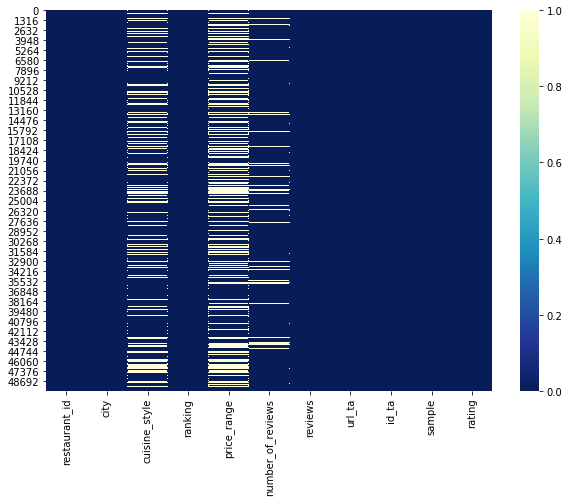

In [13]:
# Посмотрим как распеделены пропуски по датасету:
plt.figure(figsize=(10, 7))# размер тепловой карты
sns.heatmap(data.isnull(), cmap="YlGnBu_r");

In [14]:
# Посмотрим на количество пропусков у признаков
data.isnull().sum() 

restaurant_id            0
city                     0
cuisine_style        11590
ranking                  0
price_range          17361
number_of_reviews     3200
reviews                  2
url_ta                   0
id_ta                    0
sample                   0
rating                   0
dtype: int64

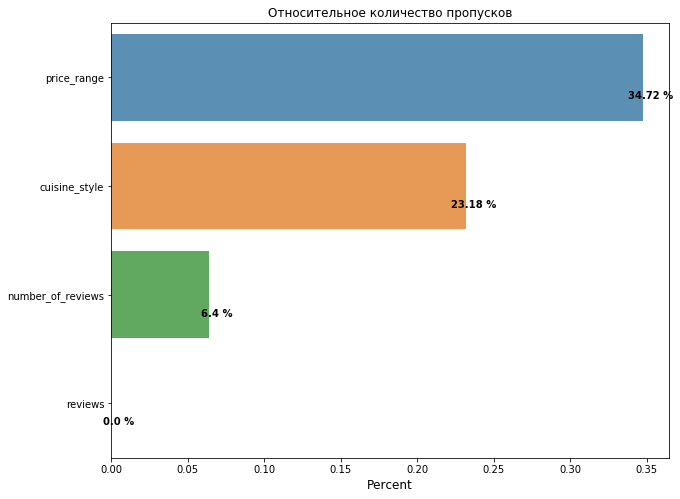

In [15]:
# Считаем процент пропусков в столбцах
per_nans = pd.DataFrame(1-data.count()/data.shape[0]).reset_index().rename({0:'percent'}, \
                                                axis=1).sort_values('percent', ascending=False).query('percent>0')
# Строим график относительного количества пропущенных значений:
fig, ax = plt.subplots(figsize = (10, 8))
bar_plot = sns.barplot(x='percent', y='index', data=per_nans, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
        bar_plot.text(per_nans.iloc[ytick][1]+0.005, ytick+0.2, str(round(per_nans.iloc[ytick][1]*100,2))+' %', 
                    horizontalalignment='center',size=10, color='black',weight='semibold')
plt.title('Относительное количество пропусков')
plt.ylabel('')
plt.xlabel('Percent', fontsize=12)
plt.show()

### Предварительные выводы о датасете

* В объединённом датасете data 50000 строк, соответствующих 50000 ресторанам. Рейтинг есть по 40000 ресторанам. Для 10000 его нужно предсказать.
* Датасет состоит из 10 столбцов: 3 типа float (ranking,rating,number_of_reviews) и 7 типа string. Это не значит, что у нас только 3 количественных признака - дальнейший анализ это прояснит. Возможно, из признаков типа string получится создать новые количественные признаки, поскольку наша ML модель принимает на вход только такие.
* Есть 4 признака, содержащих nan значения: cuisine_style, price_range, number_of_reviews и reviews. Необходимо обработать пропуски в этих признаках.
* Поля ranking и number_of_reviews имеют большой разброс данных, возможно будет необходимо нормировании.
* Признаки URL_TA и ID_TA не будем рассматривать.

#### Как видим, большинство признаков у нас требует очистки и предварительной обработки. Приступим!

# 
### Детальный анализ переменных
#### 1. restaurant_id

In [16]:
# Посмотрим есть ли у нас в датасете сетевые рестораны, с одинаковым ID должно 
# быть больше ресторанов чем один
data.restaurant_id.value_counts()

id_436      19
id_871      19
id_227      19
id_633      19
id_321      18
            ..
id_12993     1
id_16296     1
id_10758     1
id_14030     1
id_7858      1
Name: restaurant_id, Length: 13094, dtype: int64

In [17]:
# Создадим новый признак - количество ресторанов в сети
chain=data['restaurant_id'].value_counts()
chain=chain.reset_index()
chain.columns=['restaurant_id','chain_count']
data = data.merge(chain, on='restaurant_id', how='left')

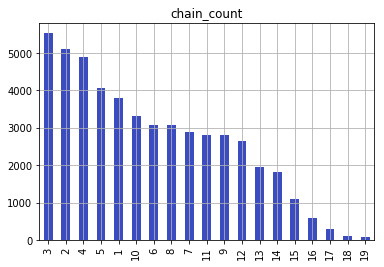

In [18]:
data['chain_count'].value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'chain_count')

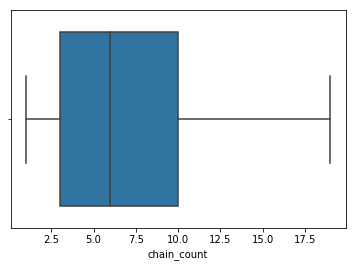

In [19]:
# Посмотрим на выбросы:
sns.boxplot(data=data, x='chain_count')
plt.show()

In [20]:
# Нормализуем методом minmax признак 'chain_count' 
# и запишем это в новый столбец 'chain_count_norm'
data['chain_count_norm'] = MinMax(data.chain_count)

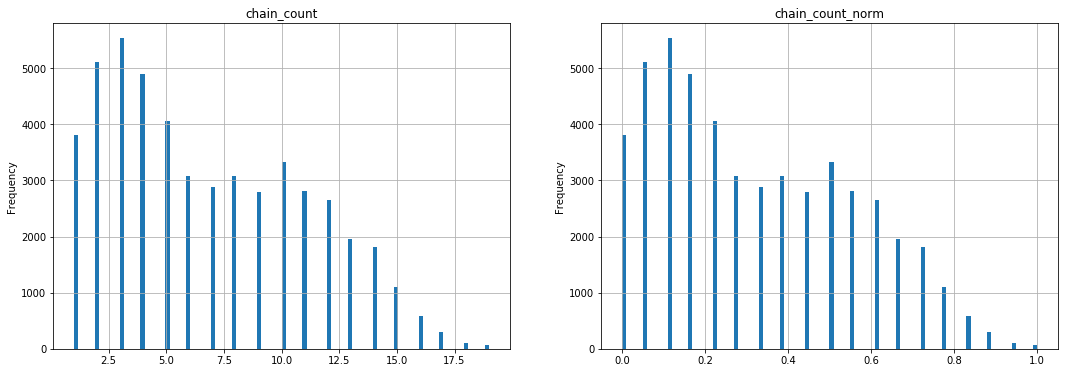

In [21]:
# Убедимся, что вид распределения не изменился
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
data['chain_count'].plot(kind='hist', bins=100, ax=axes[0], 
                         grid=True, title='chain_count')
data['chain_count_norm'].plot(kind='hist', bins=100, ax=axes[1], 
                              grid=True, title='chain_count_norm')

#### 2. city

- 'city' - категориальный признак, в столбце отсутствуют пропуски. Посмотрим, как рестораны распределены по городам, и сколько всего уникальных значений городов

In [22]:
display(data.city.value_counts())
data.city.nunique()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

31

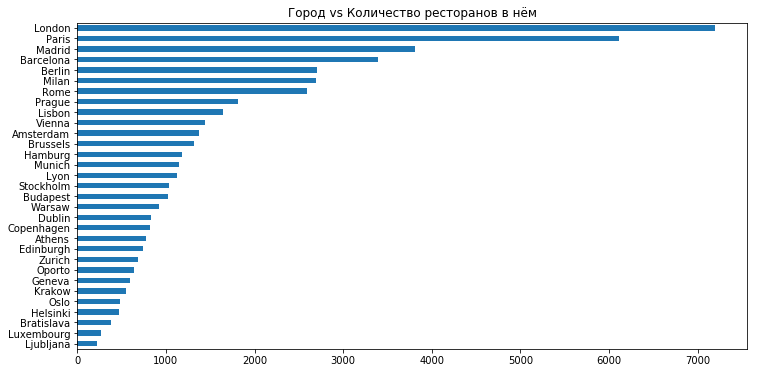

In [23]:
plt.rcParams['figure.figsize'] = (12,6)
data.city.value_counts(ascending=True).plot(kind='barh', title = 'Город vs Количество ресторанов в нём')

In [24]:
# Мы видим, что у нас 31 город. Создадим 31 новый признак по названию города (местоположению ресторана)
# с помощью метода pd.get_dummies
data_city = pd.get_dummies(data['city'], dummy_na=False).astype('int64')
data = pd.concat([data,data_city], axis=1)

In [25]:
# На всякий случай закодируем наш признак
le = LabelEncoder()
le.fit(data['city'])
data['code_city'] = le.transform(data['city'])

In [26]:
# Создадим признак: city_population (в млн)
dict_city_population = {'London': 8.982, 'Paris': 2.161, 'Madrid' : 3.266, 'Barcelona' : 1.664, 'Berlin' : 3.664, 
                        'Milan' : 1.378, 'Rome' : 2.870, 'Prague' : 1.335, 'Lisbon': 0.5055, 'Vienna' : 1.897, 
                        'Amsterdam' : 0.8727, 'Brussels' : 0.185, 'Hamburg' : 1.841, 'Munich': 1.472, 
                        'Lyon' : 0.507, 'Stockholm' : 0.976, 'Budapest' : 1.752, 'Warsaw' : 1.791, 'Dublin': 0.544,
                        'Copenhagen' : 0.616, 'Athens' : 0.664, 'Edinburgh' : 0.488, 'Zurich' : 0.429, 
                        'Oporto' : 0.232, 'Geneva' : 0.201, 'Krakow' : 0.779, 'Oslo' : 0.673, 'Helsinki' : 0.657,
                        'Bratislava' : 0.438, 'Luxembourg' : 0.125, 'Ljubljana' : 0.509} 
data['city_population'] = data['city'].map(dict_city_population)

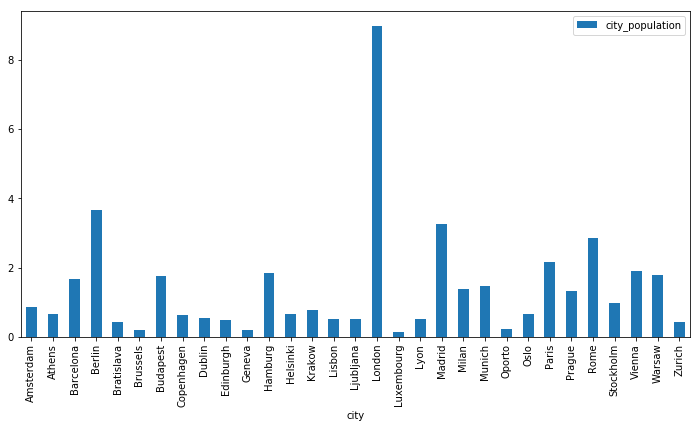

In [27]:
data.pivot_table(values = ['city_population'], 
               index = 'city', 
               aggfunc = 'mean').plot(kind = 'bar')

In [28]:
# Нормализуем методом minmax признак 'city_population' 
# и запишем это в новый столбец 'city_population_norm'
data['city_population_norm'] = MinMax(data.city_population)

In [29]:
data.sample(2)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,chain_count,chain_count_norm,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,code_city,city_population,city_population_norm
49702,id_1956,Amsterdam,"['Dutch', 'Bar', 'Pub', 'International', 'Euro...",1961.0,$$ - $$$,68.0,"[['Well for a man made beach not bad', 'Great ...",/Restaurant_Review-g188590-d2012797-Reviews-Bl...,d2012797,1,3.5,7,0.333333,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.8727,0.084419
13696,id_431,Krakow,"['Bar', 'International']",432.0,$,34.0,"[['Great local cafe for work or meetings', 'Th...",/Restaurant_Review-g274772-d8784768-Reviews-Pi...,d8784768,1,4.5,13,0.666667,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0.7790,0.073840


# 
#### 3. cuisine_style
- cuisine_style: тип кухни ресторана, категориальный признак. Посмотрим, что можно из него извлечь

In [30]:
# В переменной 11590 (23.18%) пропущенных значений 
# сохраним эту информацию
data['nan_cuisine_style'] = pd.isna(data['cuisine_style']).astype('float64') 

# Заполним пропуски значением 'Other'
data['cuisine_style'] = data['cuisine_style'].fillna("['Other']")

# # закодируем значения в переменной до их преобразования
# le = LabelEncoder()
# le.fit(data['cuisine_style'])
# data['code_cuisine_style'] = le.transform(data['cuisine_style'])

In [31]:
# Проведем обработку значений переменной: переведём их в тип list
data['cuisine_style'] = data['cuisine_style'].apply(lambda x: json.loads(x.replace("'", '"')))   

In [32]:
# Создаём список для хранения информации о уникальных значениях стилей кухни, 
# посмотрим сколько их 
cuisines = set() 
for x in data['cuisine_style']:
    cuisines.update(x)
print(len(cuisines))

126


In [33]:
# Извлечём информацию о стилях кухни и их количестве в датасете
mylist = [j for i in data.cuisine_style.tolist() for j in i]
styles = collections.Counter()
for item in mylist:
    styles[item] += 1

In [34]:
# Посмотрим порядок частоты распространения
OrderedDict(sorted(styles.items(), key=itemgetter(1), reverse=True))

OrderedDict([('Vegetarian Friendly', 14021),
             ('European', 12561),
             ('Other', 11590),
             ('Mediterranean', 7820),
             ('Italian', 7433),
             ('Vegan Options', 5684),
             ('Gluten Free Options', 5185),
             ('Bar', 4094),
             ('French', 3970),
             ('Asian', 3786),
             ('Pizza', 3502),
             ('Spanish', 3456),
             ('Pub', 3058),
             ('Cafe', 2883),
             ('Fast Food', 2122),
             ('British', 1992),
             ('International', 1966),
             ('Seafood', 1878),
             ('Japanese', 1860),
             ('Central European', 1727),
             ('American', 1642),
             ('Sushi', 1450),
             ('Chinese', 1446),
             ('Portuguese', 1385),
             ('Indian', 1328),
             ('Middle Eastern', 980),
             ('Thai', 923),
             ('Wine Bar', 877),
             ('German', 820),
             ('Halal', 773),
  

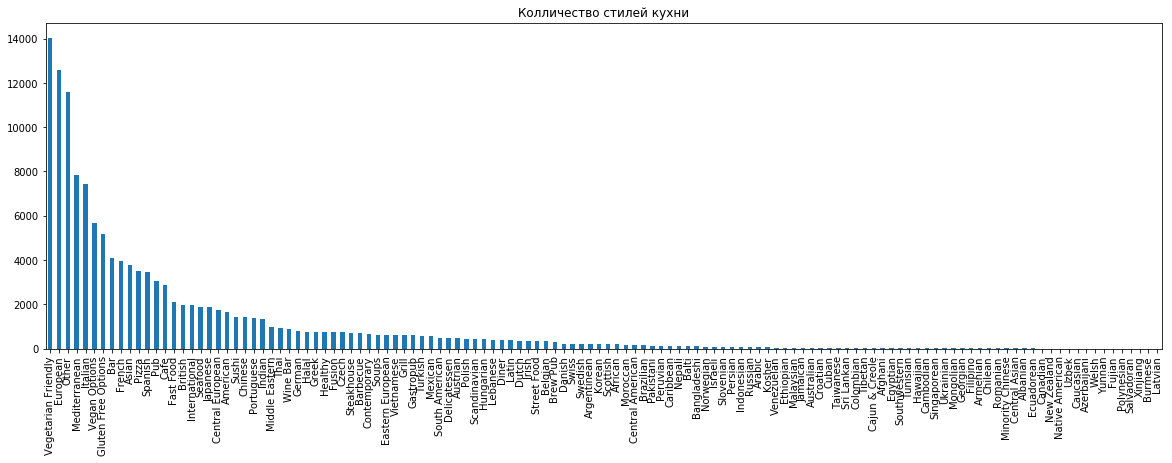

In [35]:
plt.figure(figsize=(20, 6))
pd.Series.explode(data['cuisine_style']).value_counts().plot(kind='bar', 
                                                             title='Колличество стилей кухни')

In [36]:
# сформируем список редких кухонь (частота упоминанич в датасете менее 500) 
# и сформируем на его основе новый признак
list_of_rare_сuisine = [x[0] for x in styles.most_common() if x[1] < 500]
data['rare_сuisine_style'] = data['cuisine_style'].apply(lambda x: 1 if len(set(x) & 
                                                                            set(list_of_rare_сuisine))>0  
                                                         else 0).astype('float64')
data.rare_сuisine_style.value_counts()

0.0    42234
1.0     7766
Name: rare_сuisine_style, dtype: int64

In [37]:
# Сгенерируем новый признак - количество кухонь в ресторане
data['number_cuisine_style'] = data['cuisine_style'].apply(lambda x: len(x)).astype('int64')

# Посмотрим распределение нового признака
data['number_cuisine_style'].value_counts()

1     20744
2      7794
3      6638
4      5948
5      4482
6      2611
7      1294
8       363
9        93
10       26
11        4
21        1
15        1
13        1
Name: number_cuisine_style, dtype: int64

Мы помним, что в значении столбца data['number_cuisine_style'] == 1 заложены 11590 строк с пропусками, которые мы заменили на 'Other'. Нам стоит заменить в столбце 'number_cuisine_style' значение 1 в тех стороках, где были пропуски в значении cuisine_style, на mean(), либо поскольку их очень много, а разброс в вариантах количества кухонь велик заполнить их согласно общему распределению количества кухонь в процентах по всему датасету

In [38]:
data.loc[data['nan_cuisine_style'] == 1, 'number_cuisine_style'] = np.nan
list_for_replacement = ['number_cuisine_style']
replacement_prop(data,list_for_replacement)

# Посмотрим теперь распределение признака
data['number_cuisine_style'].value_counts()

1.0     11917
2.0     10146
3.0      8641
4.0      7743
5.0      5834
6.0      3399
7.0      1684
8.0       473
9.0       121
10.0       34
11.0        5
15.0        1
13.0        1
21.0        1
Name: number_cuisine_style, dtype: int64

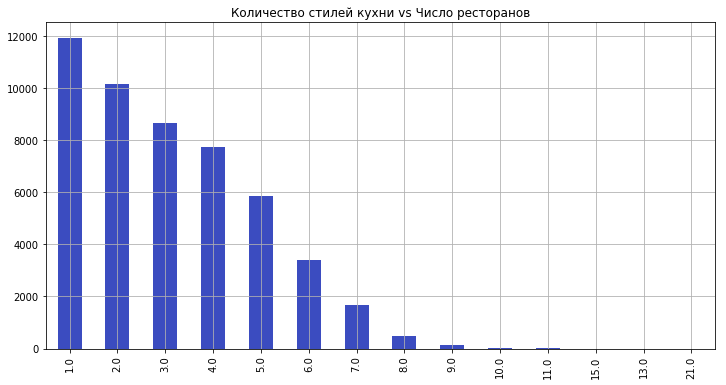

In [39]:
data.number_cuisine_style.value_counts().plot(kind = 'bar', 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Количество стилей кухни vs Число ресторанов' )

In [40]:
# Нормализуем методом minmax признак 'number_cuisine_style' 
# и запишем это в новый столбец 'number_cuisine_norm'
data['number_cuisine_norm'] = MinMax(data.number_cuisine_style)

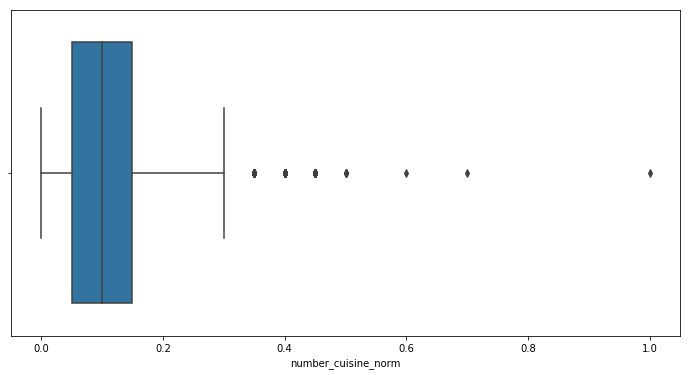

25-й перцентиль: 0.05 75-й перцентиль: 0.15000000000000002, IQR: 0.10000000000000002,  Границы выбросов: [-0.10000000000000002, 0.30000000000000004].
Выбросов, согласно IQR: 636 | 1.27%


In [41]:
# Посмотрим на выбросы:
sns.boxplot(data=data, x='number_cuisine_norm')
plt.show()
IQR_outlier('number_cuisine_norm', verbose=True)

**Итого:** Сформирован новый признак 'number_cuisine_norm'. Выбросов мало 1.27%.

# 
#### 4. ranking

- ranking — место, которое занимает данный ресторан среди всех ресторанов своего города.

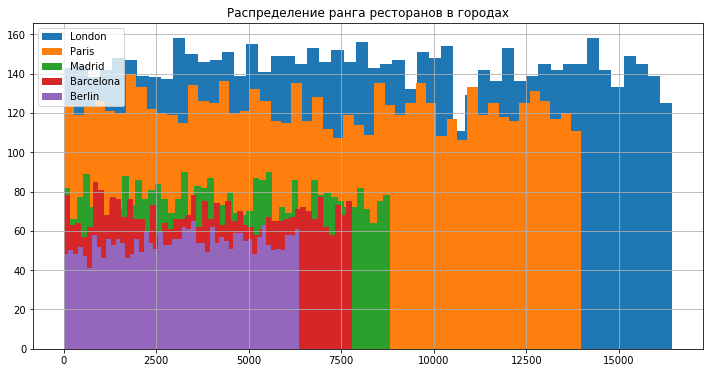

In [42]:
# Посмотрим на распределение рангов внутри городов для первых пяти городов с наибольшим числом ресторанов
сities = []
for x in (data['city'].value_counts())[0:5].index:
    data['ranking'][data['city'] == x].hist(bins=50)
    сities.append(x)
plt.legend(сities, loc=2)
plt.title('Распределение ранга ресторанов в городах')
plt.show()

Мы видим, что внутри городов ранг распределен более-менее нормально. Имеет смысл создать новый признак 'real_ranking', используя среднее mean() переменной 'ranking'

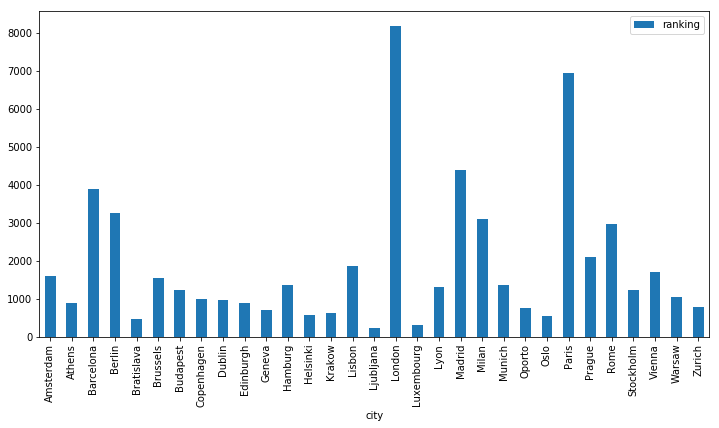

In [43]:
# Посмотрим на распределение средних значений ранга по городам
data.pivot_table(values = ['ranking'], 
               index = 'city', 
               aggfunc = 'mean').plot(kind = 'bar')
# Видим, что средний 'ranking' зависит от величины города и соответственно 
# от количества ресторанов в нём

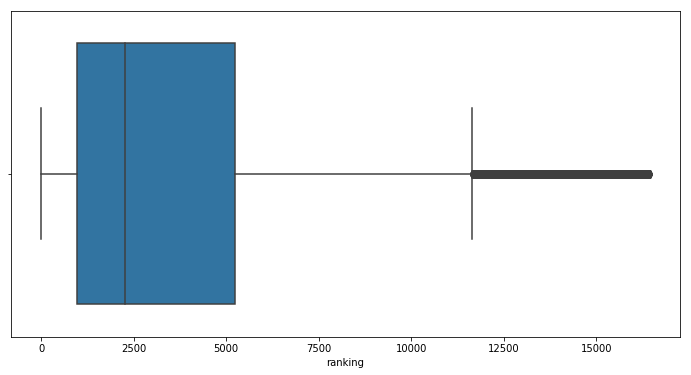

25-й перцентиль: 972.0 75-й перцентиль: 5241.0, IQR: 4269.0,  Границы выбросов: [-5431.5, 11644.5].
Выбросов, согласно IQR: 3075 | 6.15%


In [44]:
# Посмотрим на выбросы:
sns.boxplot(data=data, x='ranking')
plt.show()
IQR_outlier('ranking', verbose=True)

In [45]:
# Создадим нормализованный вручную признак 'ranking_norm'
restorans = data['city'].value_counts().rename_axis('city').to_frame(name='number_of_rest')
mean_ranking = data.groupby(['city'])['ranking'].mean().to_frame(name='mean_ranking')
data = data.merge(restorans, on='city', how='left')
data = data.merge(mean_ranking, on='city', how='left')
data['ranking_norm'] = (data['ranking'] - data['mean_ranking']) / data['number_of_rest']
data.sample(3)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,url_ta,id_ta,sample,rating,chain_count,chain_count_norm,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,code_city,city_population,city_population_norm,nan_cuisine_style,rare_сuisine_style,number_cuisine_style,number_cuisine_norm,number_of_rest,mean_ranking,ranking_norm
10829,id_2601,Paris,"[Italian, Pizza, Vegetarian Friendly]",2602.0,$$ - $$$,76.0,"[['Very pleasant surprise, awesome pizza per.....",/Restaurant_Review-g187147-d1503730-Reviews-Dr...,d1503730,1,4.5,4,0.166667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,24,2.161,0.229875,0.0,0.0,3.0,0.10,6108,6938.557138,-0.709980
901,id_901,Paris,"[French, European, Vegetarian Friendly]",684.0,NaN,1459.0,"[['Sympa, Satisfying, Easy on the Wallet', 'Lo...",/Restaurant_Review-g187147-d718650-Reviews-La_...,d718650,0,0.0,12,0.611111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,24,2.161,0.229875,0.0,0.0,3.0,0.10,6108,6938.557138,-1.023994
13702,id_5494,London,"[Cafe, British]",5503.0,$,34.0,[['Like my own (shared) central London living....,/Restaurant_Review-g186338-d6001452-Reviews-Zi...,d6001452,1,4.5,5,0.222222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,8.982,1.000000,0.0,0.0,2.0,0.05,7193,8169.707354,-0.370736


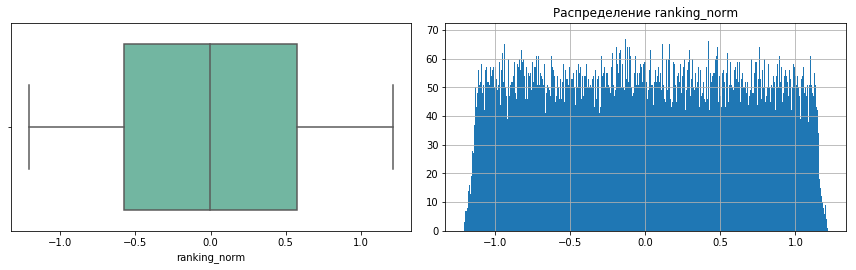

25-й перцентиль: -0.5776474089794654 75-й перцентиль: 0.576219281098023, IQR: 1.1538666900774883,  Границы выбросов: [-2.308447444095698, 2.3070193162142556].
Выбросов, согласно IQR: 0 | 0.00%


In [46]:
# Смотрим графики
fig, axes = plt.subplots(ncols=2, figsize=(6, 4))

sns.boxplot(data=data, x='ranking_norm', orient="h",
                 palette="Set2", whis=1.5, ax=axes[0]);
data['ranking_norm'].hist(bins=1000, ax=axes[1])
fig.tight_layout(rect=[-1, 0.03, 1, 0.95])
plt.title('Распределение ranking_norm')
plt.show()
IQR_outlier('ranking_norm', verbose=True)

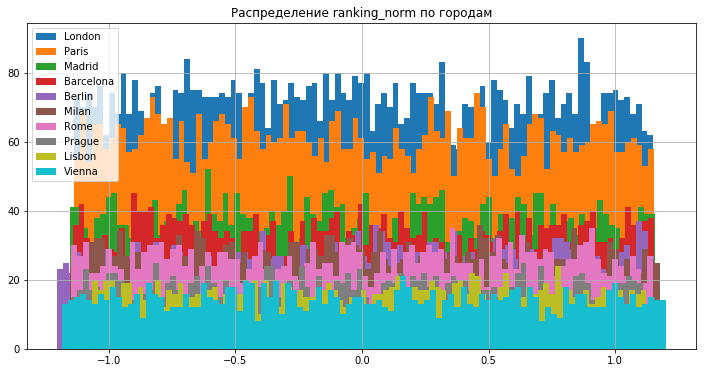

In [47]:
# Посмотрим на распределение рангов внутри городов для первых десяти городов 
# с наибольшим числом ресторанов
сities = []
for x in (data['city'].value_counts())[0:10].index:
    data['ranking_norm'][data['city'] == x].hist(bins=100)
    сities.append(x)
plt.legend(сities, loc=2)
plt.title('Распределение ranking_norm по городам')
plt.show()

In [48]:
# Удалим столбец 'mean_ranking'
data.drop('mean_ranking', axis=1, inplace=True)

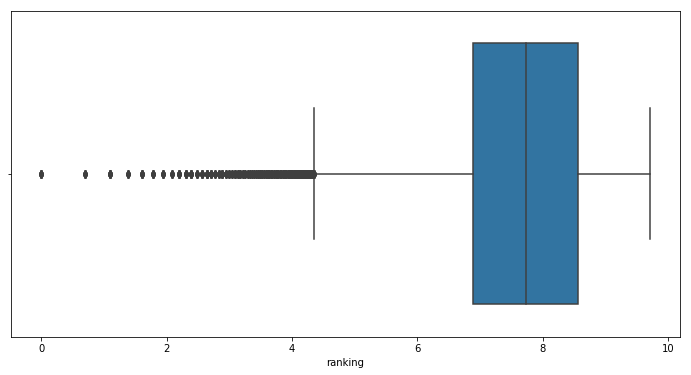

25-й перцентиль: 6.879355804460439 75-й перцентиль: 8.564267598802166, IQR: 1.684911794341727,  Границы выбросов: [4.351988112947849, 11.091635290314757].
Выбросов, согласно IQR: 1021 | 2.04%


In [49]:
# Уменьшим количество выбросов в столбце 'ranking' не меняя их явно - прологорифмируем:
data.ranking = data.ranking.apply(lambda x: np.log(x))
# Посмотрим сейчас на выбросы:
sns.boxplot(data=data, x='ranking')
plt.show()
IQR_outlier('ranking', verbose=True)

**Итого**: Сформирован новый признак 'ranking_norm'. Прологорифмирован признак 'ranking' - совсем от выбросов не избавились, но их стало заметно меньше

# 
#### 5. price_range
- price_range - диапазон цен в ресторане. Мы раннее уже выяснили, что в столбце 17361 пропуск, что составляет около 34.72% от всех значений в столбце

In [50]:
# Посмотрим какие данные содержит этот столбец. 
display(data.price_range.unique())
display(data.price_range.value_counts())

array(['$$ - $$$', '$$$$', '$', nan], dtype=object)

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

По описанию 'price_range' это - цены в ресторане.
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3

In [51]:
# В переменной 17361 (34.72%) пропущенных значений 
# сохраним эту информацию
data['nan_price_range'] = pd.isna(data['price_range']).astype('float64') 

In [52]:
# Посмотрим моды диапазона цен для каждого 'city'
dict_of_cities = {}
list_of_cities = list(data['city'].unique())
for x in list_of_cities:
    y = data[(data.city == x)].price_range.mode()[0]
    dict_of_cities.update({x: y})
dict_of_cities

{'Paris': '$$ - $$$',
 'Helsinki': '$$ - $$$',
 'Edinburgh': '$$ - $$$',
 'London': '$$ - $$$',
 'Bratislava': '$$ - $$$',
 'Lisbon': '$$ - $$$',
 'Budapest': '$$ - $$$',
 'Stockholm': '$$ - $$$',
 'Rome': '$$ - $$$',
 'Milan': '$$ - $$$',
 'Munich': '$$ - $$$',
 'Hamburg': '$$ - $$$',
 'Prague': '$$ - $$$',
 'Vienna': '$$ - $$$',
 'Dublin': '$$ - $$$',
 'Barcelona': '$$ - $$$',
 'Brussels': '$$ - $$$',
 'Madrid': '$$ - $$$',
 'Oslo': '$$ - $$$',
 'Amsterdam': '$$ - $$$',
 'Berlin': '$$ - $$$',
 'Lyon': '$$ - $$$',
 'Athens': '$$ - $$$',
 'Warsaw': '$$ - $$$',
 'Oporto': '$$ - $$$',
 'Krakow': '$$ - $$$',
 'Copenhagen': '$$ - $$$',
 'Luxembourg': '$$ - $$$',
 'Zurich': '$$ - $$$',
 'Geneva': '$$ - $$$',
 'Ljubljana': '$$ - $$$'}

Мы видим, что у всех городов она одинаковая, поэтому без колебаний заполняем пропуски в столбце общей модой

In [53]:
# Заменим пропуски модой
data['price_range'] = data['price_range'].fillna(data['price_range'].mode()[0])

In [54]:
# Создадим словарь, присвоив код имеющимся значениям переменной, 
# и заполним столбец новыми значениями
dic_price = {'$':1,'$$ - $$$':2,'$$$$':3}
data['price_range'] = data['price_range'].map(lambda x: dic_price.get(x,x))

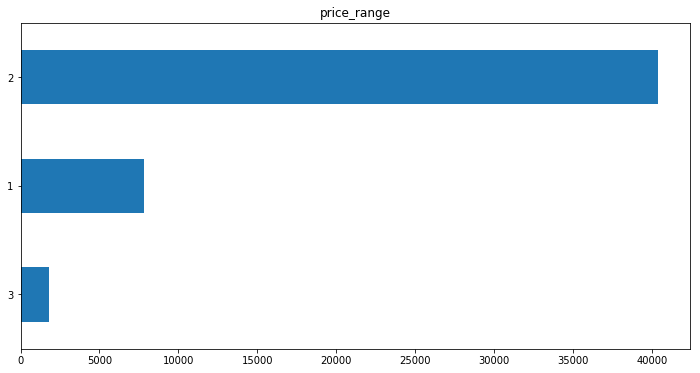

In [55]:
plt.rcParams['figure.figsize'] = (12,6)
data.price_range.value_counts(ascending=True).plot(kind='barh', title = 'price_range')

# 
#### 6. number_of_reviews

In [56]:
# number_of_reviews - колличественный признак
# Столбец имеет 3200 пропусков (6.4%), сохраним эту информацию
data['nan_number_of_reviews'] = pd.isna(data['number_of_reviews']).astype('float64')

Пропусков немного, относительно общего количества значений в столбце, поэтому заполняем их средним значением. Но сначала посмотрим, отличается ли среднее значение количества отзывов для разных городов

In [57]:
mean_counter_reviews = {}
for x in list_of_cities:
    y = round(data[(data.city == x)].number_of_reviews.mean())
    mean_counter_reviews.update({x: y})
mean_counter_reviews

{'Paris': 117,
 'Helsinki': 66,
 'Edinburgh': 238,
 'London': 138,
 'Bratislava': 52,
 'Lisbon': 128,
 'Budapest': 159,
 'Stockholm': 75,
 'Rome': 290,
 'Milan': 168,
 'Munich': 78,
 'Hamburg': 45,
 'Prague': 124,
 'Vienna': 81,
 'Dublin': 154,
 'Barcelona': 136,
 'Brussels': 93,
 'Madrid': 100,
 'Oslo': 100,
 'Amsterdam': 149,
 'Berlin': 64,
 'Lyon': 87,
 'Athens': 94,
 'Warsaw': 67,
 'Oporto': 134,
 'Krakow': 131,
 'Copenhagen': 95,
 'Luxembourg': 83,
 'Zurich': 73,
 'Geneva': 62,
 'Ljubljana': 88}

In [58]:
# Давайте заполним пропуски средним значением отзывов по каждому городу воспользовавшись
# полученным словарём
for c in data.city.unique():
    data.loc[data.city == c, 'number_of_reviews'] = \
    data[data.city == c].number_of_reviews.replace(np.nan, mean_counter_reviews[c])

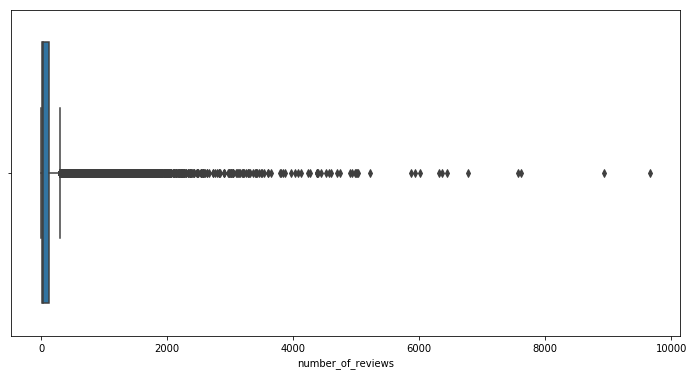

25-й перцентиль: 10.0 75-й перцентиль: 124.0, IQR: 114.0,  Границы выбросов: [-161.0, 295.0].
Выбросов, согласно IQR: 5039 | 10.08%


In [59]:
# Посмотрим на выбросы:
sns.boxplot(data=data, x='number_of_reviews')
plt.show()
IQR_outlier('number_of_reviews', verbose=True)

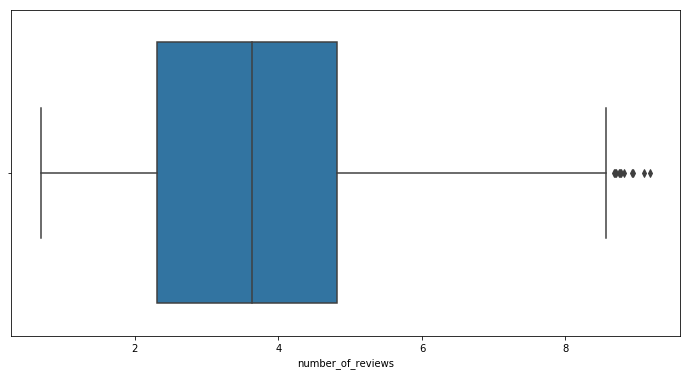

25-й перцентиль: 2.302585092994046 75-й перцентиль: 4.820281565605037, IQR: 2.517696472610991,  Границы выбросов: [-1.4739596159224408, 8.596826274521524].
Выбросов, согласно IQR: 11 | 0.02%


mean    3.594295
amax    9.175749
amin    0.693147
std     1.624641
Name: number_of_reviews, dtype: float64

In [60]:
# Избавимся от выбросов в столбце 'number_of_reviews' не меняя их явно - прологорифмируем:
data.number_of_reviews = data.number_of_reviews.apply(lambda x: np.log(x))
# Посмотрим сейчас на выбросы:
sns.boxplot(data=data, x='number_of_reviews')
plt.show()
IQR_outlier('number_of_reviews', verbose=True)
data.number_of_reviews.agg([np.mean, np.max, np.min, np.std])

**Итого**: Прологорифмирован признак 'number_of_reviews' - совсем от выбросов не избавились, но их стало заметно меньше

# 
#### 7. reviews

In [61]:
# Посмотрим на данные
data['reviews'].value_counts(dropna=False)

[[], []]                                                                                                         8112
NaN                                                                                                                 2
[['Very average food. Over average prices.', 'great food with great service!'], ['11/17/2017', '08/17/2017']]       2
[['Excellent'], ['09/03/2015']]                                                                                     2
[['Thursday snack', 'Good value for money & good food!'], ['03/13/2017', '06/20/2016']]                             2
                                                                                                                 ... 
[['Perfect Italian restaurant!', 'Bit far but good overall'], ['08/27/2016', '10/18/2015']]                         1
[['Great Schnitzel, friendly waiter'], ['12/29/2017']]                                                              1
[['GREAT FOOD', 'Amazing Portuguese cuisine with a magic

Значение признака [[], []] - это то же самое, что и пропуск. Но пока заполним наши два пропуска этим значением, поскольку оно самое популярное (т.е. mode).

In [62]:
# заполним пропуски самым популярным значением
data['reviews'].fillna(data['reviews'].mode()[0], inplace = True)

Обратим внимание, что у нас есть повторяющиеся значения в столбце - совпадения не только дословно в отзыве, но и в датах. Это наводит на мысль, что речь идет об одном ресторане. Посмотрим, сколько таких удвоений:

In [63]:
value_counts = data['reviews'].value_counts(dropna=True, sort=True)
df_reviews = pd.DataFrame(value_counts)
df_reviews_reset = df_reviews.reset_index()
df_reviews_reset.columns = ['reviews', 'counts']
display(df_reviews_reset.head())
df_reviews_reset[(df_reviews_reset.counts == 2)].counts.count()

,reviews,counts
0,"[[], []]",8114
1,"[['Great coffee and pastries, sandwiches, ver....",2
2,"[['Improve your service', 'Great value chain r...",2
3,"[['Sat night', 'Can\'t even explain.. ""A"" plac...",2
4,"[['Excellent cuisine, friendly and helpful se....",2


30

То есть совпадений 30, соответственно ресторанов таких 60. Это очень мало по сравнению с общим числом ресторанов, поэтому с этим знанием мы ничего делать пока не будем.

In [64]:
# cоздаем столбец review_dates содержащий список дат отзывов
data['date_of_review'] = data['reviews'].str.findall('\d+\/\d+\/\d+')
data['date_of_review'].sample(5)

41895    [10/13/2013, 09/23/2013]
20376    [12/03/2017, 08/29/2017]
19542    [06/25/2016, 06/17/2016]
23652                [02/11/2015]
4273     [07/04/2016, 03/02/2015]
Name: date_of_review, dtype: object

In [65]:
# посмотрим на количество review, это видно из количества дат:
data['count_review'] = data['date_of_review'].apply(lambda x: len(list(x)))
data['count_review'].value_counts()

2    36202
0     8114
1     5680
3        4
Name: count_review, dtype: int64

In [66]:
# В строках, где три отзыва мы уберём дату первого отзыва, оставив два последних
data.date_of_review = data.date_of_review.apply(lambda x: x if len(x) <= 2 else x[1:])

In [67]:
# Создадим два новых столбца: first_review (дата первого отзыва) 
# и last_review (дата последнего отзыва) со значениями в формате datetime
data['first_review'] = data['date_of_review'].apply(lambda x: pd.to_datetime(x).min())
data['last_review'] = data['date_of_review'].apply(lambda x: pd.to_datetime(x).max())
# Создадим признак difference_dates с разницей между первым и вторым отзывом в днях
data['difference_dates'] = (data['last_review'] - data['first_review']).apply(lambda x: x.days)
# Заполним пропуски средним значением
# data['difference_dates'].fillna(round(data['difference_dates'].mean()), inplace=True)

In [68]:
mean_difference_dates = {}
for x in list_of_cities:
    y = round(data[(data.city == x)].difference_dates.mean())
    mean_difference_dates.update({x: y})
mean_difference_dates

{'Paris': 147,
 'Helsinki': 142,
 'Edinburgh': 65,
 'London': 94,
 'Bratislava': 143,
 'Lisbon': 112,
 'Budapest': 107,
 'Stockholm': 128,
 'Rome': 122,
 'Milan': 151,
 'Munich': 140,
 'Hamburg': 180,
 'Prague': 120,
 'Vienna': 138,
 'Dublin': 87,
 'Barcelona': 123,
 'Brussels': 145,
 'Madrid': 132,
 'Oslo': 114,
 'Amsterdam': 79,
 'Berlin': 153,
 'Lyon': 164,
 'Athens': 117,
 'Warsaw': 126,
 'Oporto': 97,
 'Krakow': 103,
 'Copenhagen': 103,
 'Luxembourg': 131,
 'Zurich': 131,
 'Geneva': 142,
 'Ljubljana': 121}

In [69]:
# Заполним наши 8114 пропусков в столбце средними значениями по городам
for c in data.city.unique():
    data.loc[data.city == c, 'difference_dates'] = \
    data[data.city == c].difference_dates.replace(np.nan, mean_difference_dates[c])

In [70]:
# удалим столбцы date_of_review, count_review, first_review и last_review
data.drop(['date_of_review', 'count_review', 'first_review', 'last_review'], axis=1, inplace=True)

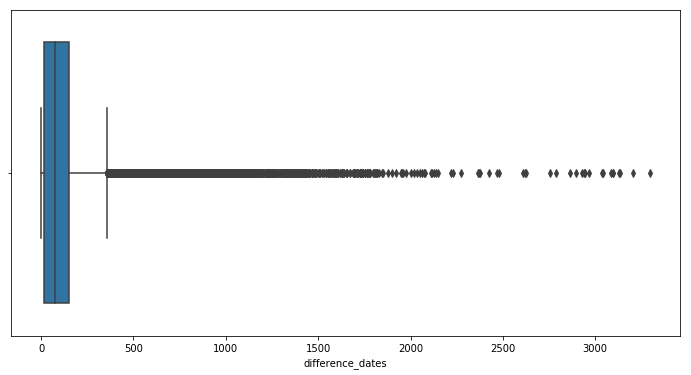

25-й перцентиль: 13.0 75-й перцентиль: 151.0, IQR: 138.0,  Границы выбросов: [-194.0, 358.0].
Выбросов, согласно IQR: 3492 | 6.98%


mean     125.475100
amax    3296.000000
amin       0.000000
std      194.785484
Name: difference_dates, dtype: float64

In [71]:
# Посмотрим на выбросы:
sns.boxplot(data=data, x='difference_dates')
plt.show()
IQR_outlier('difference_dates', verbose=True)
data.difference_dates.agg([np.mean, np.max, np.min, np.std])

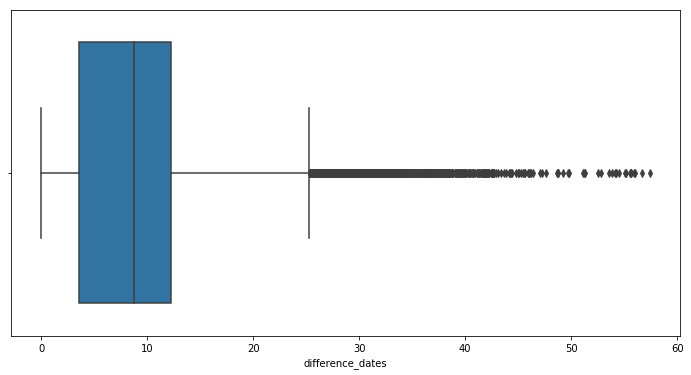

25-й перцентиль: 3.605551275463989 75-й перцентиль: 12.288205727444508, IQR: 8.682654451980518,  Границы выбросов: [-9.418430402506788, 25.312187405415287].
Выбросов, согласно IQR: 1245 | 2.49%


In [72]:
# Избавимся от выбросов в столбце 'difference_dates' не меняя их явно 
# - возьмём квадратный корень:
data.difference_dates = data.difference_dates.apply(lambda x: np.sqrt(x))
# Посмотрим сейчас на выбросы:
sns.boxplot(data=data, x='difference_dates')
plt.show()
IQR_outlier('difference_dates', verbose=True)

**Итого:** Мы видим довольно большой разброс значений. Максимальная разница между последним и предпоследним отзывом 3296 дней - это почти 10 лет. Скорее всего этот признак окажется неинформативным для нашей модели, но корреляционная таблица покажет.

# 
#### 8. url_ta

In [73]:
data.url_ta[0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

В столбце url_ta значениями являются ссылки на отзывы о конкретных ресторанах, пока я не умею извлекать полезную информацию из таких данных, поэтому просто удалю данный столбец.

In [74]:
data.drop('url_ta', axis=1, inplace=True)

# 
#### 9. id_ta

In [75]:
data.id_ta.value_counts()

d5618007     2
d3748757     2
d11921719    2
d7827387     2
d9877640     2
            ..
d692129      1
d10748320    1
d1017303     1
d11911398    1
d1039595     1
Name: id_ta, Length: 49963, dtype: int64

In [76]:
# Посмотрим, какие два ресторана соответствуют одному значению id_ta
data[(data.id_ta == 'd2360290')]

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,id_ta,sample,rating,chain_count,chain_count_norm,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,code_city,city_population,city_population_norm,nan_cuisine_style,rare_сuisine_style,number_cuisine_style,number_cuisine_norm,number_of_rest,ranking_norm,nan_price_range,nan_number_of_reviews,difference_dates
4209,id_4209,Madrid,"[Japanese, Sushi, Asian, Thai]",8.092545,2,4.343805,"[['Great Asian Option', 'Wow'], ['10/16/2017',...",d2360290,0,0.0,4,0.166667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,19,3.266,0.354635,0.0,0.0,4.0,0.15,3813,-0.293343,0.0,0.0,20.099751
46934,id_3140,Madrid,"[Japanese, Sushi, Asian, Thai]",8.052615,2,4.343805,"[['Great Asian Option', 'Wow'], ['10/16/2017',...",d2360290,1,3.5,6,0.277778,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,19,3.266,0.354635,0.0,0.0,4.0,0.15,3813,-0.326912,0.0,0.0,20.099751


In [77]:
# Посмотрим, сколько у нас совпадений по id_ta
value_counts = data['id_ta'].value_counts(dropna=True, sort=True)
df_id_ta = pd.DataFrame(value_counts)
df_id_ta_reset = df_id_ta.reset_index()
df_id_ta_reset.columns = ['id_ta', 'counts']
df_id_ta_reset[(df_id_ta_reset.counts == 2)].counts.count()

37

Возможно, это какой-то ID ресторана для Tripadvisor внутреннего пользования. Но, если взять допустим данные по любому id_ta, которых больше, чем один, то рестораны с одинаковым id_ta очень похожи, если не сказать, что это один и тот же ресторан, только один из датасета df_train с уже известным значение 'raiting', а другой из df_test без такового. Но таких совпадений всего 37, поэтому этим знанием можем пренебречь. Для построения модели признак не информативен, поэтому тоже удалим его.

In [78]:
data.drop('id_ta', axis=1, inplace=True)

#### 10. rating

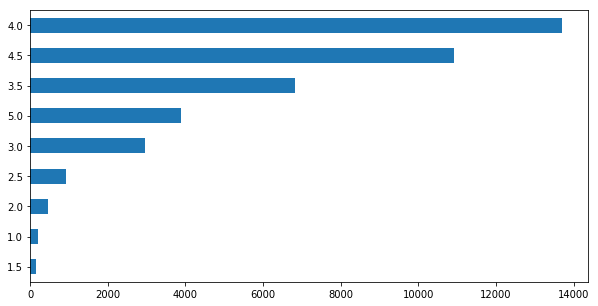

In [79]:
# посмотрим распределение целевой переменной
data[(data['sample'] == 1)]['rating'].value_counts(ascending=True
                                                  ).plot(figsize=(10, 5), kind='barh')

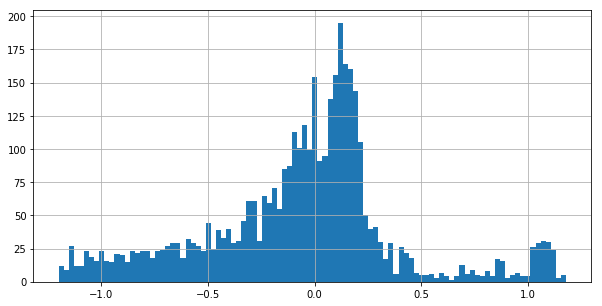

In [80]:
# посмотрим распределение целевой переменной относительно признака ranking_norm = 5:
data[(data['sample'] == 1)]['ranking_norm'][data[(data['sample'] == 1)]['rating'] == 5
                                      ].hist(figsize=(10, 5), bins=100);

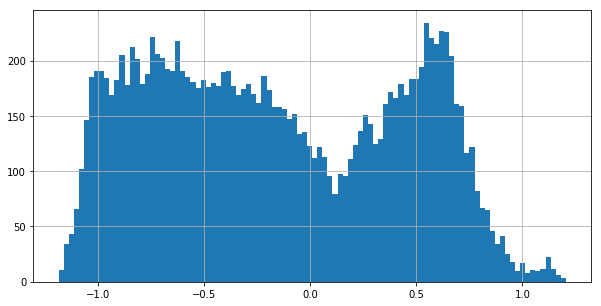

In [81]:
# посмотрим распределение целевой переменной относительно признака ranking_norm = 4:
data[(data['sample'] == 1)]['ranking_norm'][data[(data['sample'] == 1)]['rating'] == 4
                                      ].hist(figsize=(10, 5), bins=100);

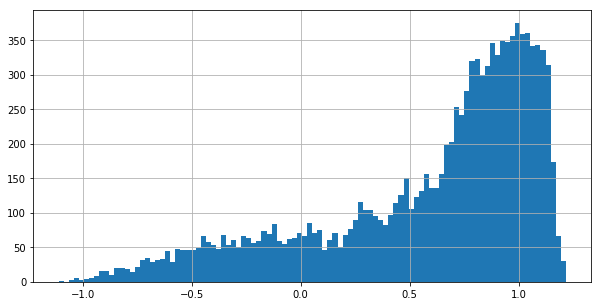

In [82]:
data[(data['sample'] == 1)]['ranking_norm'][data[(data['sample'] == 1)]['rating'] < 4
                                      ].hist(figsize=(10, 5), bins=100);

# 
### Корреляционный анализ

In [83]:
data.head(2)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,sample,rating,chain_count,chain_count_norm,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,code_city,city_population,city_population_norm,nan_cuisine_style,rare_сuisine_style,number_cuisine_style,number_cuisine_norm,number_of_rest,ranking_norm,nan_price_range,nan_number_of_reviews,difference_dates
0,id_0,Paris,"[Bar, Pub]",9.469854,2,1.386294,"[[], []]",0,0.0,16,0.833333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,24,2.161,0.229875,0.0,0.0,2.0,0.05,6108,0.986320,0.0,0.0,12.124356
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",4.663439,2,4.574711,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,10,0.500000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0.657,0.060065,0.0,1.0,5.0,0.20,475,-0.964698,0.0,0.0,6.082763


In [84]:
# Сформируем список признаков, которые исключаем из корреляционного анализа
columns_to_drop = ['sample', 'Amsterdam', 'Athens', 'Barcelona', 'Bratislava', 
                'Brussels','Budapest', 'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 
                'Hamburg', 'Helsinki', 'Krakow', 'Lisbon', 'Ljubljana', 'Luxembourg',
                'Lyon', 'Madrid','Milan', 'Munich', 'Oporto', 'Oslo', 'Prague',
                'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich', 'nan_cuisine_style', 
                'nan_price_range', 'nan_number_of_reviews', 'number_of_rest',
                'chain_count', 'city_population', 'number_cuisine_style']
# 'London', 'Paris', 'Berlin',

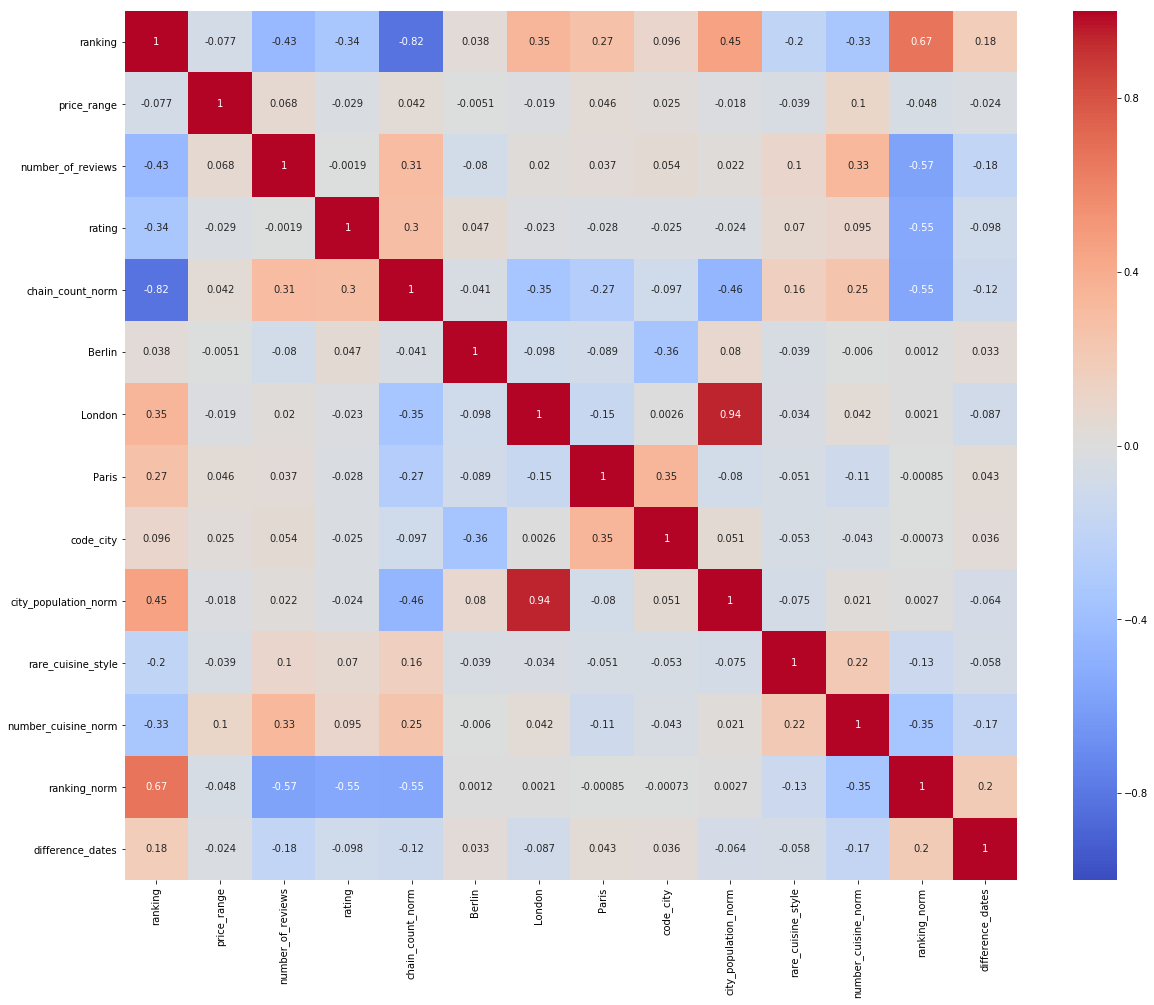

In [85]:
plt.figure(figsize=(20, 16))
data_corr = data.copy()

sns.heatmap(data_corr[data_corr['sample']== 1].drop(
    columns_to_drop, axis=1).corr(),annot=True,fmt='.2g', 
            vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [86]:
data[data['sample']== 1].corr().rating.sort_values(ascending=False).to_frame()

,rating
rating,1.000000
chain_count,0.296471
chain_count_norm,0.296471
number_cuisine_norm,0.095017
number_cuisine_style,0.095017
Rome,0.083082
rare_сuisine_style,0.069872
Berlin,0.046967
Athens,0.044792
Amsterdam,0.034535


С нашей целевой переменной больше всего коррелируют ranking и ranking_norm.

In [87]:
# Убираем сильно коррелирующие между собой признаки:
data.drop(['city_population','chain_count', 
           'number_cuisine_style'], axis = 1, inplace=True)

In [88]:
# убираем не числовые признаки 
object_columns = [x for x in data.columns if data[x].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [89]:
data.head(5)

,ranking,price_range,number_of_reviews,sample,rating,chain_count_norm,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,code_city,city_population_norm,nan_cuisine_style,rare_сuisine_style,number_cuisine_norm,number_of_rest,ranking_norm,nan_price_range,nan_number_of_reviews,difference_dates
0,9.469854,2,1.386294,0,0.0,0.833333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,24,0.229875,0.0,0.0,0.05,6108,0.986320,0.0,0.0,12.124356
1,4.663439,2,4.574711,0,0.0,0.500000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0.060065,0.0,1.0,0.20,475,-0.964698,0.0,0.0,6.082763
2,6.697034,2,3.332205,0,0.0,0.777778,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0.040985,0.0,0.0,0.00,745,-0.100846,0.0,0.0,4.690416
3,7.419980,3,5.308268,0,0.0,0.444444,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,1.000000,0.0,0.0,0.20,7193,-0.903755,0.0,0.0,3.741657
4,3.610918,3,5.087596,0,0.0,0.722222,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0.035339,0.0,0.0,0.25,380,-1.119550,0.0,0.0,3.872983


# 
### **Разбиваем датасет на тренировочный и тестовый**

In [90]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = data.drop(['rating'], axis = 1)
y = data['rating']

In [91]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data['rating'] # наш таргет
X = train_data.drop(['rating'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [92]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных.
# Наборы данных с меткой "train" будут использоваться для обучения модели, 
# "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=RANDOM_SEED)

In [93]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 46), (40000, 46), (40000, 45), (30000, 45), (10000, 45))

# Model 
Сам ML

In [94]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [95]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [96]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [97]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20815


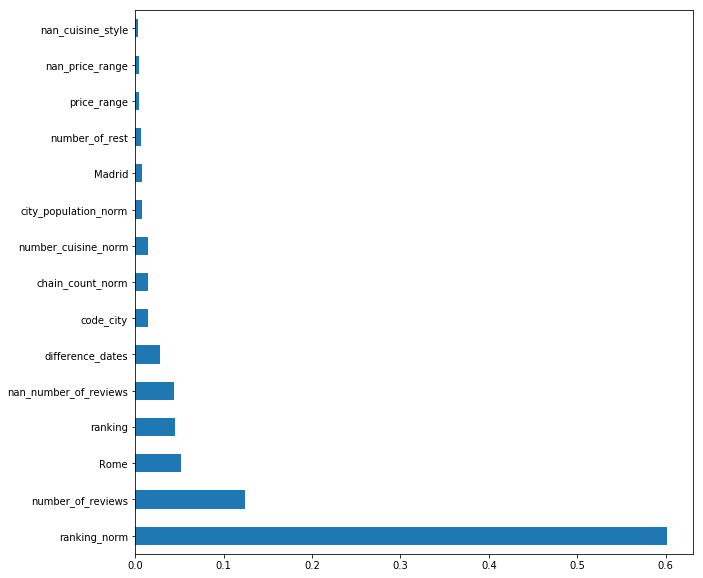

In [98]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# 
### Submission
Если все устраевает - готовим Submission на кагл

In [99]:
test_data.sample(10)

,ranking,price_range,number_of_reviews,rating,chain_count_norm,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,code_city,city_population_norm,nan_cuisine_style,rare_сuisine_style,number_cuisine_norm,number_of_rest,ranking_norm,nan_price_range,nan_number_of_reviews,difference_dates
1452,5.164786,2,4.499810,0.0,0.388889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,27,0.096082,0.0,0.0,0.25,1033,-1.028540,0.0,0.0,0.000000
509,6.267201,2,5.648974,0.0,0.722222,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0.042960,0.0,0.0,0.20,1647,-0.813801,0.0,0.0,15.099669
4629,8.471777,2,3.178054,0.0,0.111111,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0.399571,0.0,0.0,0.05,2705,0.562877,0.0,0.0,12.806248
9958,7.970740,2,3.295837,0.0,0.055556,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0.399571,1.0,0.0,0.00,2705,-0.133241,1.0,0.0,10.954451
8348,7.418181,2,2.397895,0.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.084419,0.0,1.0,0.05,1372,0.054235,0.0,0.0,10.148892
9114,1.098612,2,6.359574,0.0,0.055556,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0.008581,0.0,0.0,0.15,590,-1.203775,0.0,0.0,2.000000
5046,7.447751,1,4.219508,0.0,0.166667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,20,0.141470,0.0,0.0,0.15,2694,-0.515972,0.0,0.0,15.842980
6606,7.066467,2,3.178054,0.0,0.166667,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0.040985,0.0,1.0,0.15,745,0.385060,0.0,0.0,2.449490
9016,7.884200,1,0.693147,0.0,0.111111,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,21,0.152083,0.0,0.0,0.15,1145,1.122011,0.0,0.0,11.832160
4348,8.743213,1,1.386294,0.0,0.222222,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.173761,0.0,0.0,0.05,3395,0.703557,0.0,0.0,1.732051


In [100]:
test_data = test_data.drop(['rating'], axis=1)

In [101]:
sample_submission

,restaurant_id,rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [102]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [103]:
# Так как признак рейтинга имеет шаг 0.5, округляем предсказание.
predict_submission = np.round(predict_submission * 2) / 2
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4.5, 4.5])

In [104]:
sample_submission['rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,restaurant_id,rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
